In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import keras
import keras.utils
from keras import utils as np_utils

In [3]:
import tensorflow.keras.layers
import tensorflow as tf



In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adam
import cv2
import numpy as np


In [9]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
train_datagen_with_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen_with_aug.flow_from_directory(
    r'/content/drive/My Drive/DR',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='categorical',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/content/drive/My Drive/DR', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
    ) # set as validation data

input_img = Input(shape=(224, 224, 3))

Found 1984 images belonging to 5 classes.
Found 496 images belonging to 5 classes.


In [14]:
from keras.applications import densenet

DENSENET_201 = Sequential()

densenet201_model = keras.applications.densenet.DenseNet201(
    include_top=False, weights='imagenet',
    input_shape=(224,224,3), pooling=('max'), classes=5
)

74836368/74836368 [==============================] - 0s 0us/step


In [16]:
import keras
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
import tensorflow.keras.applications


# Load DenseNet-169 model without top layers
densenet201_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a Sequential model
DENSENET_201 = keras.models.Sequential()

# Set layers in densenet169_model to non-trainable
for layer in densenet201_model.layers:
    layer.trainable = False

# Add layers to the model
DENSENET_201.add(densenet201_model)
DENSENET_201.add(Flatten())
DENSENET_201.add(Dropout(0.2))
DENSENET_201.add(Dense(1024, activation='relu'))
DENSENET_201.add(Dropout(0.2))
DENSENET_201.add(Dense(512, activation='relu'))
DENSENET_201.add(Dense(5, activation='softmax'))

# Compile the model
adam = Adam(learning_rate=0.001)
DENSENET_201.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

# Assuming you have your ImageDataGenerators set up
# train_generator = ...
# validation_generator = ...

# Train the model
graph = DENSENET_201.fit(train_generator, epochs=25, validation_data=validation_generator)
DENSENET_201.save("/content/drive/My Drive/DENSENET_201(ADAM_0.001).h5")

# Print the results
print(graph.history)


Epoch 1/25
62/62 [==============================] - 677s 11s/step - loss: 7.4892 - accuracy: 0.6179 - precision_m: 0.6200 - recall_m: 0.6159 - f1_m: 0.6177 - val_loss: 2.0212 - val_accuracy: 0.7399 - val_precision_m: 0.7616 - val_recall_m: 0.7246 - val_f1_m: 0.7423
Epoch 2/25
62/62 [==============================] - 15s 235ms/step - loss: 1.0316 - accuracy: 0.7319 - precision_m: 0.7443 - recall_m: 0.7233 - f1_m: 0.7335 - val_loss: 0.5494 - val_accuracy: 0.7843 - val_precision_m: 0.8108 - val_recall_m: 0.7520 - val_f1_m: 0.7800
Epoch 3/25
62/62 [==============================] - 15s 234ms/step - loss: 0.6409 - accuracy: 0.7782 - precision_m: 0.7891 - recall_m: 0.7666 - f1_m: 0.7776 - val_loss: 0.5564 - val_accuracy: 0.7944 - val_precision_m: 0.8107 - val_recall_m: 0.7695 - val_f1_m: 0.7893
Epoch 4/25
62/62 [==============================] - 15s 232ms/step - loss: 0.5937 - accuracy: 0.7742 - precision_m: 0.7933 - recall_m: 0.7611 - f1_m: 0.7766 - val_loss: 0.6819 - val_accuracy: 0.7944 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


{'loss': [7.489227771759033, 1.0315810441970825, 0.6408532857894897, 0.5936502814292908, 0.4785379469394684, 0.4922252297401428, 0.43284380435943604, 0.3864624500274658, 0.3272721469402313, 0.31176966428756714, 0.3423072397708893, 0.34091925621032715, 0.26981082558631897, 0.3120739758014679, 0.2975049912929535, 0.24656203389167786, 0.21046236157417297, 0.26237040758132935, 0.17606966197490692, 0.1917864978313446, 0.2439246028661728, 0.27966684103012085, 0.2904126048088074, 0.15620370209217072, 0.16353707015514374], 'accuracy': [0.617943525314331, 0.7318548560142517, 0.7782257795333862, 0.774193525314331, 0.8230846524238586, 0.8165322542190552, 0.8442540168762207, 0.8487903475761414, 0.8729838728904724, 0.8896169066429138, 0.8714717626571655, 0.8744959831237793, 0.8941532373428345, 0.8770161271095276, 0.8795362710952759, 0.9087701439857483, 0.9183467626571655, 0.9017137289047241, 0.9309476017951965, 0.9238911271095276, 0.9163306355476379, 0.8881048560142517, 0.8931451439857483, 0.935987

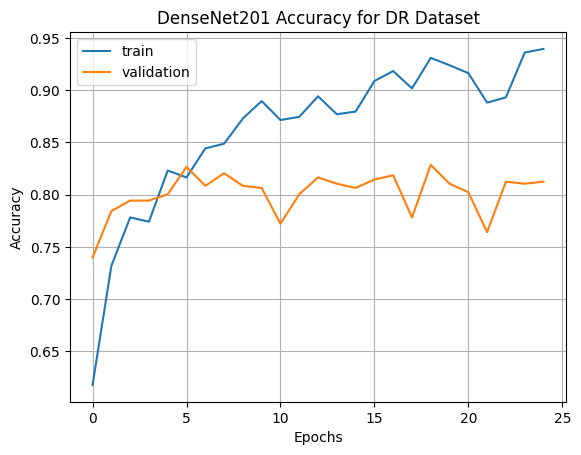

In [17]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['accuracy'])
plt.plot(graph.history['val_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('DenseNet201 Accuracy for DR Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

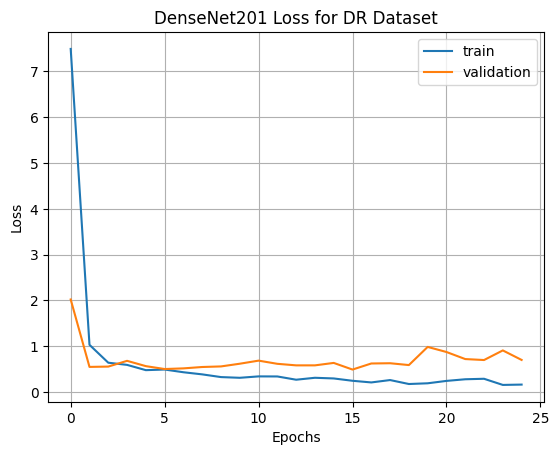

In [18]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('DenseNet201 Loss for DR Dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()